<a href="https://colab.research.google.com/github/Auzek2002/Kidney_Stone_Tumor_Cyst_Detection/blob/main/Kidney_Stone_Tumor_Cyst_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dependencies**

In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from zipfile import ZipFile
import os,glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from sklearn import preprocessing
from keras.layers import BatchNormalization
from zipfile import ZipFile
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

# **Downloading the Data**

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [4]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

100% 1.52G/1.52G [01:11<00:00, 24.1MB/s]
100% 1.52G/1.52G [01:11<00:00, 22.8MB/s]


# **Extracting the Data**

In [5]:
file = "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
cyst = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst'
normal = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal'
stone = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone'
Tumor = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor'
print(f"Number of Normal Kidney Images in dataset: {len(normal)}")
print(f"Number of Cyst Kidney Images in dataset: {len(cyst)}")
print(f"Number of Stone Kidney Images in dataset: {len(stone)}")
print(f"Number of Tumor Kidney Images in dataset: {len(Tumor)}")

Number of Normal Kidney Images in dataset: 99
Number of Cyst Kidney Images in dataset: 97
Number of Stone Kidney Images in dataset: 98
Number of Tumor Kidney Images in dataset: 98


In [7]:
x = []
y = []
class_names = ['Cyst','Normal', 'Stone', 'Tumor']
img_size = 224
for i in class_names:
    folder_path = os.path.join('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img,(img_size,img_size))
        x.append(img)
        y.append(i)


In [8]:
print(len(x))
print(len(y))

12446
12446


# **Data Augmentation**

In [9]:
!pip install split_folders

In [10]:
import splitfolders
splitfolders.ratio("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone", output="dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 12446 files [00:06, 2012.15 files/s]


In [11]:
channels=3
batch_size=25
test_batch_size=32
test_steps=1
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_gen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

train_generator = train_gen.flow_from_directory(directory=train_path, batch_size=batch_size,class_mode='categorical',target_size=(224,224), shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_path, batch_size=test_batch_size,class_mode='categorical',target_size=(224,224), shuffle=False)

val_generator = val_datagen.flow_from_directory(directory=val_path, batch_size=batch_size,class_mode='categorical',target_size=(224,224), shuffle=True)

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


# **Building the Neural Network**

In [12]:
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [13]:
def add_on_layers(class_num,model):
  top_model=model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(64,activation='relu')(top_model)
  top_model = Dense(32,activation='relu')(top_model)
  top_model = Dense(16,activation='relu')(top_model)
  top_model = Dense(class_num,activation='softmax')(top_model)
  return top_model

In [14]:
head = add_on_layers(4,vgg)
model = Model(inputs=vgg.input,outputs=head)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Neural Network Structure**

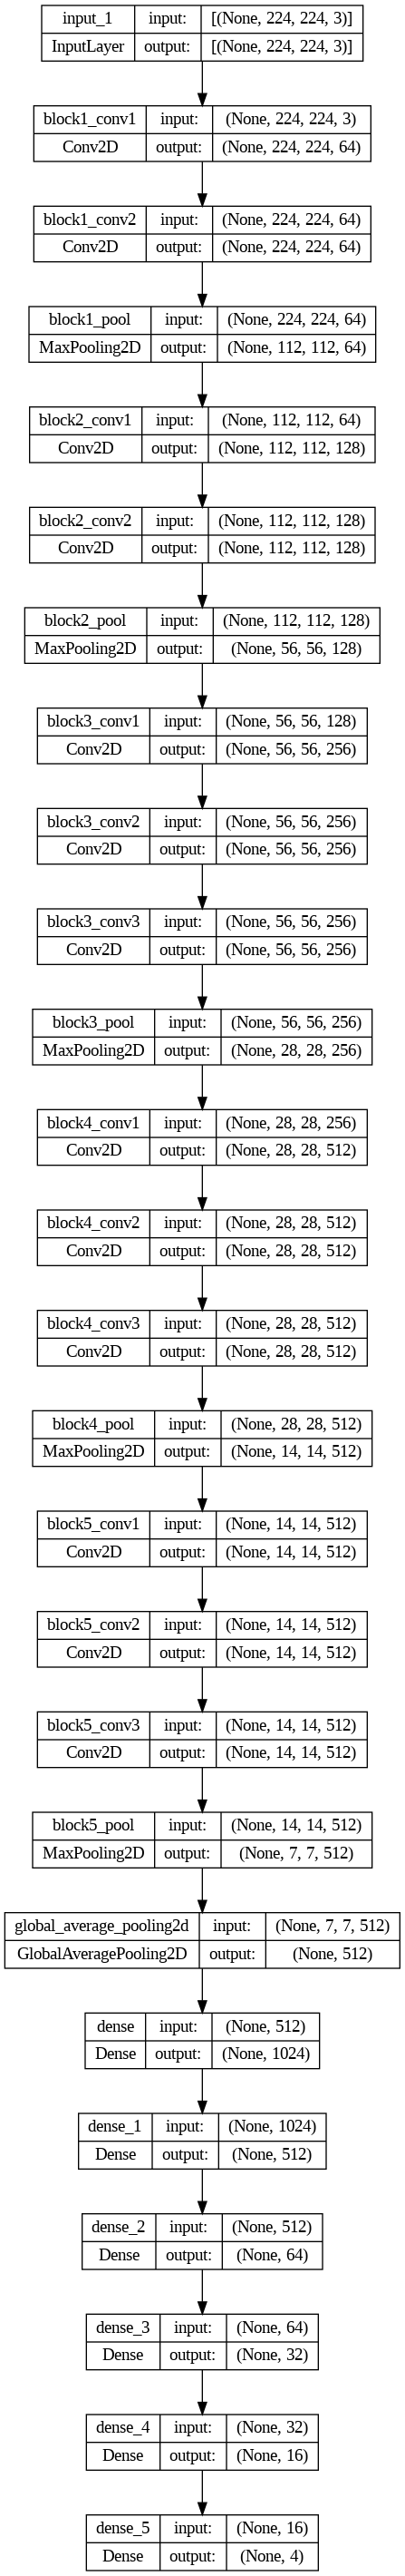

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Compiling the Model**

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics= ['accuracy'])

# **Training the Model**

In [18]:
history = model.fit(train_generator,validation_data=val_generator,epochs=10)

Epoch 1/10
399/399 [==============================] - 182s 431ms/step - loss: 0.6683 - accuracy: 0.7428 - val_loss: 0.5926 - val_accuracy: 0.8011
Epoch 2/10
399/399 [==============================] - 166s 416ms/step - loss: 0.3187 - accuracy: 0.8851 - val_loss: 0.1980 - val_accuracy: 0.9308
Epoch 3/10
399/399 [==============================] - 167s 417ms/step - loss: 0.2308 - accuracy: 0.9159 - val_loss: 0.1837 - val_accuracy: 0.9364
Epoch 4/10
399/399 [==============================] - 171s 428ms/step - loss: 0.1844 - accuracy: 0.9343 - val_loss: 0.1703 - val_accuracy: 0.9380
Epoch 5/10
399/399 [==============================] - 166s 415ms/step - loss: 0.1559 - accuracy: 0.9435 - val_loss: 0.2306 - val_accuracy: 0.9090
Epoch 6/10
399/399 [==============================] - 173s 434ms/step - loss: 0.1345 - accuracy: 0.9510 - val_loss: 0.1658 - val_accuracy: 0.9356
Epoch 7/10
399/399 [==============================] - 167s 419ms/step - loss: 0.1142 - accuracy: 0.9578 - val_loss: 0.1068 -

# **Model Evaluation**

In [21]:
loss , acc = model.evaluate(test_generator)
print(f'Accuracy on test data: {acc*100:.2f}%')

40/40 [==============================] - 8s 194ms/step - loss: 0.1267 - accuracy: 0.9584
Accuracy on test data: 95.84%


# **Plotting the training loss vs val loss**

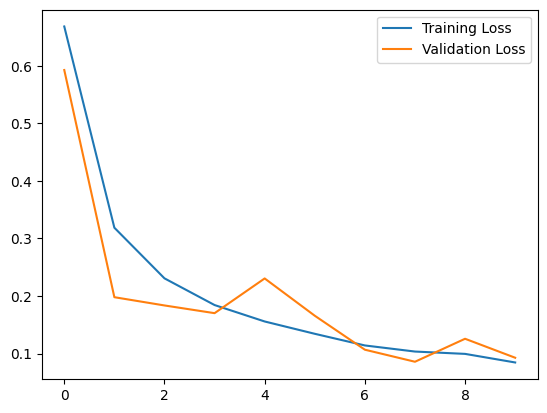

In [22]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

# **Plotting the training acc vs val acc**

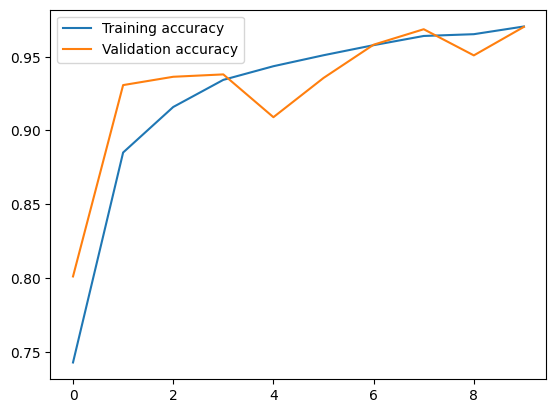

In [23]:
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.legend()
plt.show()


# **Making Predictions/Detections**

# **Detecting Cyst:**

([], [])

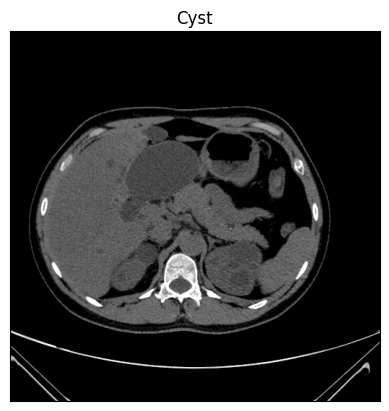

In [36]:
class_names = ['Cyst','Normal','Stone','Tumor']
img1 = '/content/dataset/test/Cyst/Cyst- (1216).jpg'
img1 = cv2.imread(img1)
plt.title("Cyst")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])

In [28]:
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [29]:
p1 = model.predict(img1)

1/1 [==============================] - 0s 28ms/step


In [30]:
print(f"The prediction is: {class_names[np.argmax(p1)]}")

The prediction is: Cyst


# **Another one:**

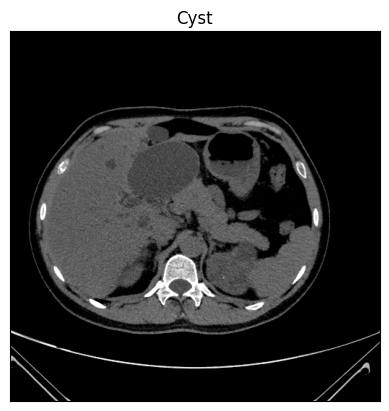

In [38]:
img1 = '/content/dataset/test/Cyst/Cyst- (1061).jpg'
img1 = cv2.imread(img1)
plt.title("Cyst")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [39]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 20ms/step
The prediction is: Cyst


# **Detecting Tumor:**

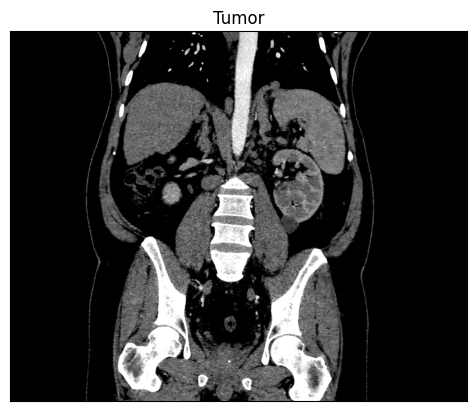

In [40]:
img1 = '/content/dataset/test/Tumor/Tumor- (1044).jpg'
img1 = cv2.imread(img1)
plt.title("Tumor")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [41]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 19ms/step
The prediction is: Tumor


# **Another one:**

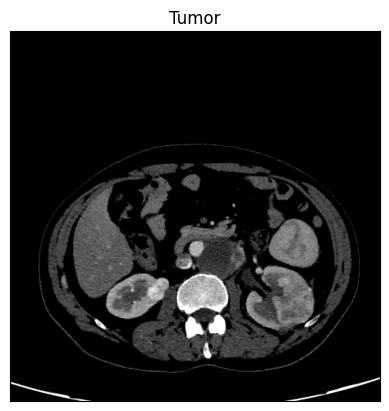

In [42]:
img1 = '/content/dataset/test/Tumor/Tumor- (1089).jpg'
img1 = cv2.imread(img1)
plt.title("Tumor")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [43]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 19ms/step
The prediction is: Tumor


# **Detecting Stone:**

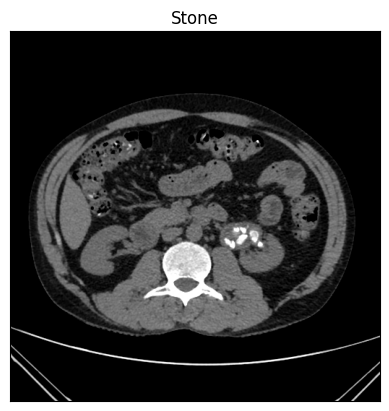

In [44]:
img1 = '/content/dataset/test/Stone/Stone- (1070).jpg'
img1 = cv2.imread(img1)
plt.title("Stone")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [45]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 32ms/step
The prediction is: Stone


# **Another one:**

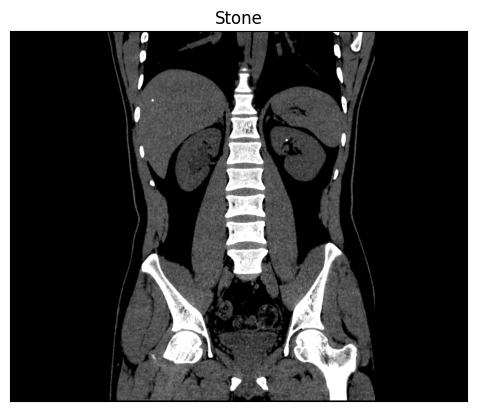

In [52]:
img1 = '/content/dataset/test/Stone/Stone- (769).jpg'
img1 = cv2.imread(img1)
plt.title("Stone")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [53]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 19ms/step
The prediction is: Stone


# **Checking if model can detect normal Kidneys:**

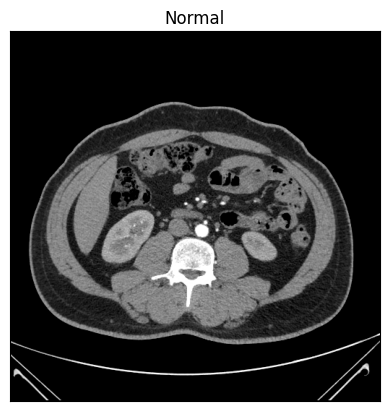

In [54]:
img1 = '/content/dataset/test/Normal/Normal- (103).jpg'
img1 = cv2.imread(img1)
plt.title("Normal")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [55]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 20ms/step
The prediction is: Normal


# **Another One:**

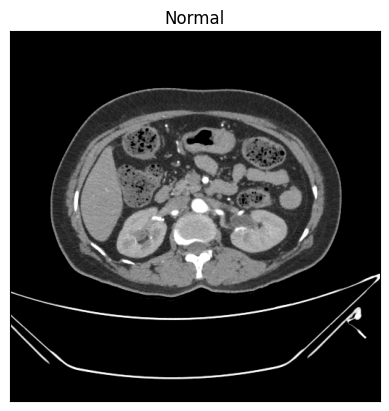

In [56]:
img1 = '/content/dataset/test/Normal/Normal- (1498).jpg'
img1 = cv2.imread(img1)
plt.title("Normal")
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img1 = cv2.resize(img1,(224,224))
img1 = np.reshape(img1,[1,224,224,3])

In [57]:
p1 = model.predict(img1)
print(f"The prediction is: {class_names[np.argmax(p1)]}")

1/1 [==============================] - 0s 21ms/step
The prediction is: Normal


# **Confusion Matrix:**

In [60]:
def print_info( test_gen, preds, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)

    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 40:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

40/40 [==============================] - 10s 243ms/step


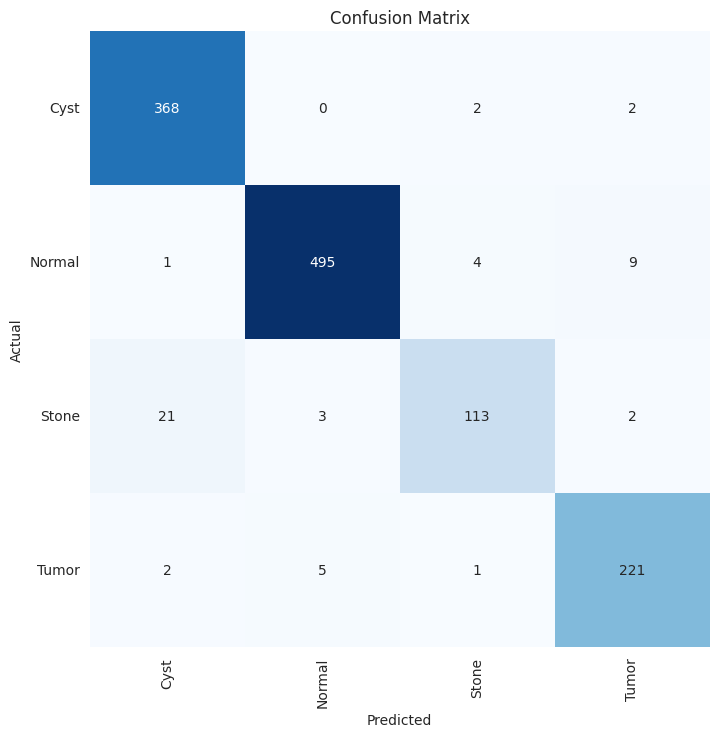

Classification Report:
----------------------
               precision    recall  f1-score   support

        Cyst       0.94      0.99      0.96       372
      Normal       0.98      0.97      0.98       509
       Stone       0.94      0.81      0.87       139
       Tumor       0.94      0.97      0.95       229

    accuracy                           0.96      1249
   macro avg       0.95      0.93      0.94      1249
weighted avg       0.96      0.96      0.96      1249



In [65]:
sns.set_style('dark')
p = model.predict(test_generator)
print_info( test_generator, p, r'./', 'kidney')